<a href="https://colab.research.google.com/github/MateoProjects/TFM/blob/main/Stable_Diffusion_TFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Requirements

In [ ]:
!pip install -qq diffusers transformers scipy ftfy
!pip install -qq "ipywidgets>=7,<8"


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title Login {display-mode:"form"}
from google.colab import output
output.enable_custom_widget_manager()
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


## Download model

In [ ]:
#@title Select model that you want { run: "auto", display-mode: "form" }
from torch import autocast
from diffusers import StableDiffusionPipeline, LMSDiscreteScheduler
import torch
# this will substitute the default PNDM scheduler for K-LMS  
lms = LMSDiscreteScheduler(
    beta_start=0.00085, 
    beta_end=0.012, 
    beta_schedule="scaled_linear"
)
model = "high precision"#@param ["low precision", "high precision"]
#@markdown **Note**: Low precision consum less memory and it's more efficient.
if 'pipe' in locals() or 'pipe' in globals():
  del pipe 
  torch.cuda.empty_cache()

if model == "low precision":
  pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16, use_auth_token=True).to("cuda")
# high precision
else:
  pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", use_auth_token=True).to("cuda")

#StableDiffusionPipeline.save_pretrained(pipe, save_directory=".")
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid






## Prompt images

In [ ]:
#@title Inputs { run: "auto", display-mode: "form" }
imagine = 'landscape photo of an unknown new magical breathtaking alien world. dof. bokeh. by artgerm and greg rutkowski. ultra reallistic. extremely detailed. Nikon D850. Award winning photography.' #@param {type:"string"}
style = '' #@param ["", "Oil painting", "Cosmic", "Sinister", "Anime", "Manga", "Fantasy"]
other = '' #@param {type:"string"}
num_inference_steps = 100 #@param {type:"integer"}
guidance_scale = 7.5 #@param


imagine = "% s ,% s ,% s"%(imagine, style, other)
num_inference_steps = num_inference_steps if num_inference_steps > 0 else 50


In [ ]:
#@title Configuration of output { run: "auto", display-mode: "form" }
num_images = 3 #@param {type:"integer"}
height = "512" #@param [256, 512, 1024]
width = "512" #@param [256, 512, 1024]
rows = 1 #@param {type:"integer"}
cols = 3 #@param {type:"integer"}


0it [00:00, ?it/s]

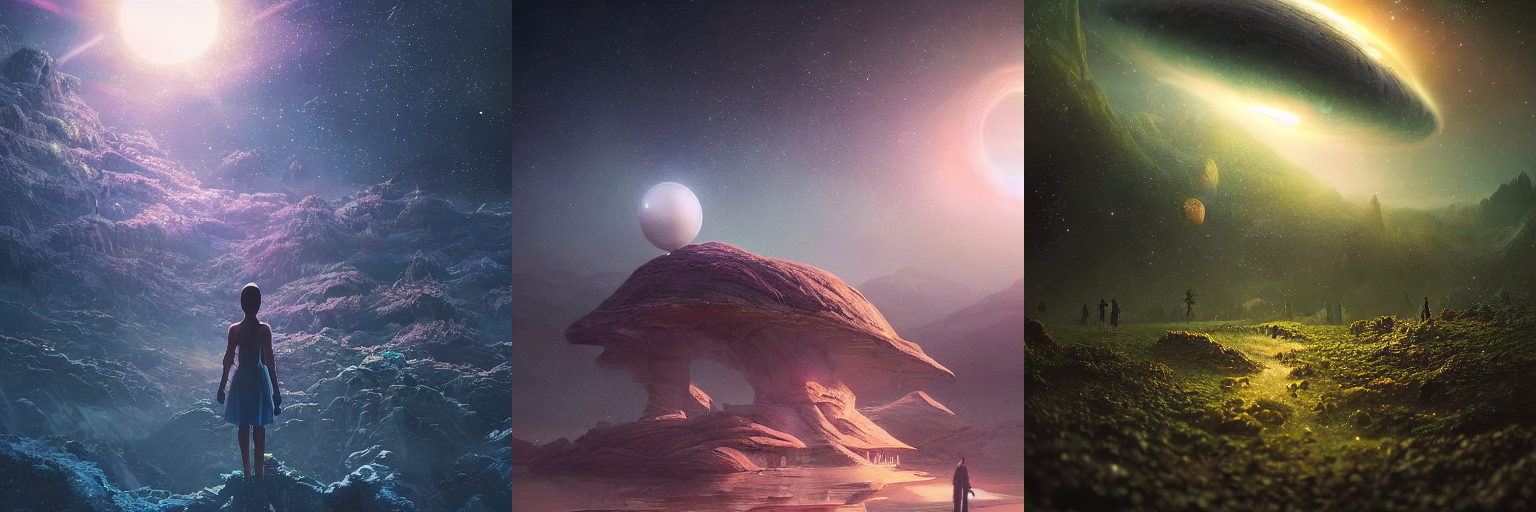

In [ ]:
#@title Push play for imagine  {display-mode: "form"}
prompt = [imagine] * num_images
generator = torch.Generator("cuda").manual_seed(1024)
with autocast("cuda"):
  images = pipe(prompt, height=int(height), width=int(width), 
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                generator=generator)["sample"]

grid = image_grid(images, rows=rows, cols=cols)
grid
